# Project 4: Web Scrapping Job Postings

## Background of the project
You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

1. Determine the industry factors that are most important in predicting the salary amounts for these data.
2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

## Introduction
The hiring agency, which is currently expanding, wants to remain competitive in the job market so as to be able to win more contracts. This is only made possible by making use of current data and technological and scientific solutions. In accomplishing the goals of getting more contracts, we need to build models that can help determine the salary and the job categories and titles.

## Materials and Methods

### Dataset
The dataset has to be obained from the jobs website - myfuturecareer.sg - which have information of salary range, seniority, job category along with text of the job description. As the job website is managed by the government, there exist sepecifications of the features that are required for the job post in the website. This includes requiring the publication of salary range and having the salary range to be limited to 1.5 to 2 times the minimum salary offered for the job.
The code which is used to scrape the website and generate the final data set is in the appendix as program listing.

### Modelling
The target variable are variable derived from running the models using the selected feature from the dataset. The main features are the job description which is a combination of both responsibility and requirements. The main feature is vectorized using CountVectors and only the token with description of number of years (of experience) and tokens with more than 2 words (that have at least three characters and exclude numbers) are selected, as they are considered significant with respect to the target variable. Two classification models are build for each target variable - using Random Forest and Naive Bayes. 

### Models to predict salary
A salary category - the target variable - is given to each median salary (determined by the average of minimum salary and maximum salary) in order to build a classification model. Only jobs with salary category of between 1 and 4 (median salary of between \$2000 and \$10000) are included as the dataset for building the model. 

In addition, to satisfy the requirement of having to predict the salary incorrectly with a lower salary instead of a higher salary, a new model will be built based on the two models built for salary category prediction. The target variable to be used will be salary categories based on the minimum salary while the feature to be used for prediction is job description.

### Models to predict job category
The models built will predict the seniority of the position. However, given the variance in the description of seniority in each job post, a seniority class (Junior, Middle & Senior) will be given only to seniority description that do not have a mixture of seniority (such as having all three seniority classes in a single job post).

In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

## Pre-modelling - Feature Engineering and Analysis

In [416]:
# Load the scrapped data from the csv file.
csv_jobs = './jobs_set.csv'
df_jobs = pd.read_csv(csv_jobs)

### Feature engineering of salary
Based on salary, the salary category is assigned in blocks of \$2000 from \$2000 to \$10000. Salary of less than \$2000 are category 0 while salary of more than or equal to \$10000 are category 5.

In [417]:
# Assign salary category for each salary amount
def get_salary_category(salary):
    if (salary < 2000):
        return 0
    elif (salary < 10000):
        return int((salary - 2000)/2000) + 1
    else:
        return 5

In [418]:
df_jobs['median_salary'] = (df_jobs['min_salary'] + df_jobs['max_salary'])/2
df_jobs['salary_category'] = df_jobs['median_salary'].map(get_salary_category)
df_jobs['min_salary_category'] = df_jobs['min_salary'].map(get_salary_category)

In [419]:
df_jobs['description'] = df_jobs['responsibilities'].str.cat(df_jobs['requirements'], sep='\n')

In [420]:
df_jobs.head()

,company,job_categories,keyword,max_salary,min_salary,requirements,responsibilities,seniority,title,url,median_salary,salary_category,min_salary_category,description
0,SINGAPORE AIRLINES LIMITED,Information Technology,AI Engineer,9000,4500,Possess a degree in Information Technology or...,"Develop, integrate and maintain in-house AI a...","Professional, Senior Executive",Solution Engineer (Contact Centre AI& Cognitiv...,https://www.mycareersfuture.sg/job/439752e1995...,6750.0,3,2,"Develop, integrate and maintain in-house AI a..."
1,ASUS GLOBAL PTE. LTD.,Sciences / Laboratory / R&D,AI Engineer,5000,4000,• Master's Degree in Information Engineering...,• Use machine learning to solve computer visio...,Professional,AI & Machine learning engineer,https://www.mycareersfuture.sg/job/6d29536e195...,4500.0,2,2,• Use machine learning to solve computer visio...
2,AMADEUS GDS SINGAPORE PTE. LTD.,"Banking and Finance, Information Technology",Business Analyst,8000,5000,Diploma/Degree level IT qualification Minimum ...,The Senior Commercial Business Analyst for Tra...,Senior Executive,Senior Commerical Business Analyst,https://www.mycareersfuture.sg/job/0886f382baf...,6500.0,3,2,The Senior Commercial Business Analyst for Tra...
3,APPLE SOUTH ASIA PTE. LTD.,Others,Business Analyst,12000,6000,7 years experience Extensive experience in rep...,The Business Analyst is responsible for the Bu...,Executive,Decision Support Business Analyst,https://www.mycareersfuture.sg/job/acab0018bf4...,9000.0,4,3,The Business Analyst is responsible for the Bu...
4,APPLE SOUTH ASIA PTE. LTD.,Others,Business Analyst,10000,5000,5 years experience Extensive experience in rep...,The Business Analyst is responsible for the Bu...,Executive,Decision Support Business Analyst,https://www.mycareersfuture.sg/job/e007ced3547...,7500.0,3,2,The Business Analyst is responsible for the Bu...


### Initial Data Analysis of Seniority and Job Category

Before carrying out any feature engineering involving seniority, I seek to understand the statistics of seniority and job category labels.

In [421]:
df_jobs['job_categories'].value_counts()

Information Technology                                                                                                572
Banking and Finance                                                                                                   115
Sciences / Laboratory / R&D                                                                                           113
Engineering                                                                                                            81
Others                                                                                                                 38
Banking and Finance, Information Technology                                                                            28
Engineering, Information Technology                                                                                    24
Engineering, Sciences / Laboratory / R&D                                                                               21
Consulting              

In [422]:
# Understand seniority category 
df_jobs['seniority'].value_counts()

Professional                                                                                                304
Executive                                                                                                   276
Senior Executive                                                                                            147
Non-executive                                                                                                75
Manager                                                                                                      70
Middle Management                                                                                            59
Junior Executive                                                                                             51
Fresh/entry level                                                                                            34
Professional, Executive                                                                                 

From the seniority labels, a small amount of job descriptions have a mix of junior, middle and senior positions. As such the seniority of the position cannot be determined and are excluded from the modelling to predict the seniority of the position.

### Feature engineering of seniority

In [423]:
list_junior = ['Junior Executive', 'Fresh/entry level', 'Executive, Junior Executive', 
               'Fresh/entry level, Executive', 'Fresh/entry level, Non-executive',
               'Fresh/entry level, Junior Executive', 'Fresh/entry level, Professional',
               'Executive, Non-executive, Junior Executive',
               'Fresh/entry level, Executive, Non-executive',
               'Fresh/entry level, Professional, Executive, Non-executive',
               'Manager, Fresh/entry level, Executive, Junior Executive',
              'Manager, Fresh/entry level, Executive, Non-executive', 
               'Fresh/entry level, Professional, Non-executive',
              'Manager, Fresh/entry level, Professional, Executive']
list_middle = ['Professional', 'Executive', 'Non-Executive', 'Manager', 'Middle Management', 'Professional, Executive',
               'Middle Management, Professional', 'Manager, Executive', 'Professional, Non-executive',
               'Executive, Non-executive', 'Middle Management, Executive', 'Senior Management, Manager',
               'Manager, Professional', 'Manager, Professional, Executive']
list_senior = ['Senior Executive', 'Executive, Senior Executive', 'Senior Management', 
               'Professional, Senior Executive', 'Manager, Professional, Senior Executive',
               'Manager, Executive, Senior Executive', 'Manager, Professional, Executive, Senior Executive',
              'Senior Management, Manager, Executive']
def get_seniority_class(seniority):
    seniority = seniority.strip()
    return "Junior" if seniority in list_junior else "Middle" if seniority in list_middle else "Senior" if seniority in list_senior else ""

df_jobs['seniority_class'] = df_jobs['seniority'].map(get_seniority_class)

In [424]:
df_jobs[df_jobs['seniority'] == 'Senior Management'].head()

,company,job_categories,keyword,max_salary,min_salary,requirements,responsibilities,seniority,title,url,median_salary,salary_category,min_salary_category,description,seniority_class
146,TECHCOM SOLUTIONS PTE. LTD.,"Banking and Finance, Information Technology",Business Analyst,8000,4500,8-12 years’ experience – Wealth management pr...,8-12 years’ experience – Wealth management pr...,Senior Management,Business Analyst,https://www.mycareersfuture.sg/job/22874339079...,6250.0,3,2,8-12 years’ experience – Wealth management pr...,Senior
148,TECHCOM SOLUTIONS ASIA PACIFIC PTE. LTD.,Banking and Finance,Business Analyst,8000,5000,8-12 years’ experience – Wealth management pr...,8-12 years’ experience – Wealth management pr...,Senior Management,Business Analyst,https://www.mycareersfuture.sg/job/8110aca47c3...,6500.0,3,2,8-12 years’ experience – Wealth management pr...,Senior
229,STARCOM MEDIA WORLDWIDE,Advertising / Media,Business Analyst,16500,10000,Minimum Bachelor’s Degree in Computer Science...,We seek creative individuals who combine stron...,Senior Management,Regional Business Intelligence (BI) Analyst,https://www.mycareersfuture.sg/job/56d44b52bd2...,13250.0,5,5,We seek creative individuals who combine stron...,Senior
230,ZENITHOPTIMEDIA,Advertising / Media,Business Analyst,16500,10000,Minimum Bachelor’s Degree in Computer Science...,We seek creative individuals who combine stron...,Senior Management,Regional Business Intelligence (BI) Analyst,https://www.mycareersfuture.sg/job/f651a0182ab...,13250.0,5,5,We seek creative individuals who combine stron...,Senior
355,CIMB BANK BERHAD,Banking and Finance,Business Intelligence,11000,10000,"• Bachelor’s degree or equivalent experience, ...",The Role serve as primary custodian across th...,Senior Management,"Head, Data and Information Security",https://www.mycareersfuture.sg/job/4eab9054bf3...,10500.0,5,5,The Role serve as primary custodian across th...,Senior


In [425]:
# Check the statistics of seniority classes.
df_jobs['seniority_class'].value_counts()

Middle    754
Senior    204
Junior    129
          125
Name: seniority_class, dtype: int64

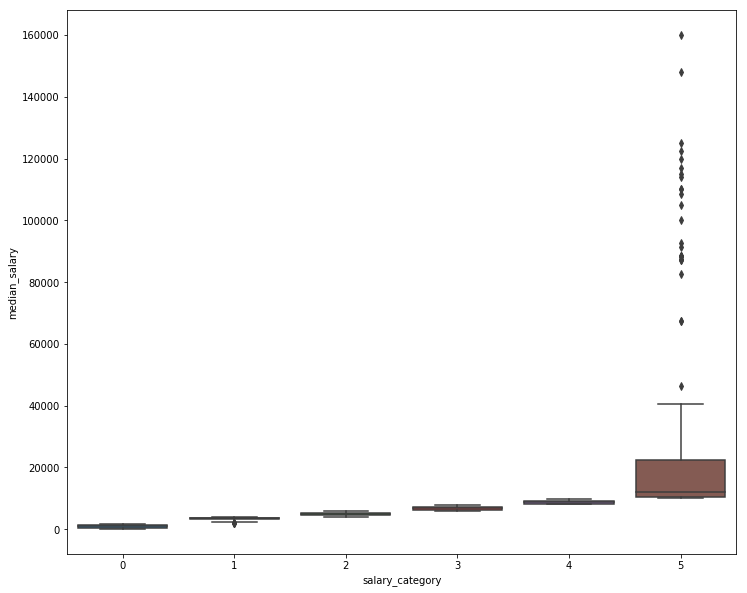

In [426]:
# Understand the salary range in each salary category, especially at salary category 0 and category 5.
plt.figure(figsize=(12, 10))
sns.boxplot(x='salary_category', y='median_salary', data=df_jobs)
plt.show()

It can be seen that for salary category 5, the salary range is relatively high and outliers are existent. In addition, there are little quantative features that can be used to predict the salary using regression.

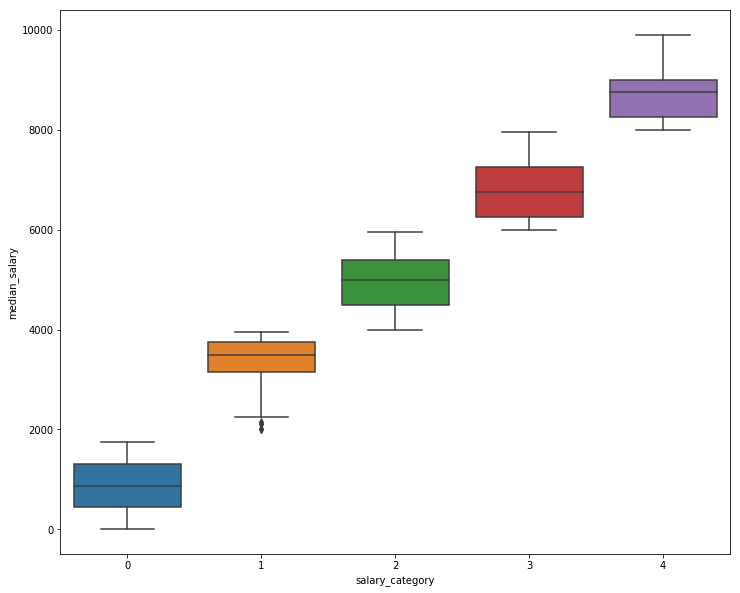

In [427]:
# Visualize the salary range in each category.
plt.figure(figsize=(12, 10))
sns.boxplot(x='salary_category', y='median_salary', data=df_jobs[df_jobs['salary_category'] != 5])
plt.show()

In [428]:
# Check the statistics of the salary category.
df_jobs['salary_category'].value_counts()

2    374
3    361
1    184
4    169
5    122
0      2
Name: salary_category, dtype: int64

The salary of the jobs in salary category of 1 to 4 (where the jobs provide median salary of between \$2000 and \$10000 per month) are distributed normally. There are too little samples from salary category 0 as compared to other salary categories.

## Factors that impact salary - Results

In [429]:
# There are to few jobs with salary category of 0 and the median salary range for jobs in salary category of 5 is too
# wide. Therefore we will exclude it from the modelling in this section.

df_jobs_selected = df_jobs[(df_jobs['salary_category'] != 0) & (df_jobs['salary_category'] != 5)].copy()

In [430]:
X1 = df_jobs_selected['description']
y1 = df_jobs_selected['salary_category']

In [431]:
# Split the dataset between training and test set.
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=45)

In [432]:
# Base accuracy values for test set
y1_test.value_counts()/len(y1_test)

3    0.338235
2    0.330882
4    0.169118
1    0.161765
Name: salary_category, dtype: float64

In [433]:
# Preprocessing
# As the feature selected is text, it has to be vectorized before fitting the model.
# Significant tokens includes the number of years of experiences and words of more than three characters.
# Numbers itself does not have any meaning.
cV_1a = CountVectorizer(stop_words='english', strip_accents='unicode', analyzer='word', token_pattern='\d+ years|[A-Za-z]{3,}', ngram_range=(2, 5))

In [434]:
# Modelling using Random Forest Classifier
rfC_1a = RandomForestClassifier(n_estimators=17, max_features=200)

pipeline_1a = Pipeline([
    ('vect', cV_1a),
    ('rf', rfC_1a)
])

pipeline_1a.fit(X1_train, y1_train)

# Initial validation of test set on the model using Random Forest.
pipeline_1a.score(X1_test, y1_test)

0.4264705882352941

In [435]:
# Understand the accuracy of the model using confusion matrix
cF1 = confusion_matrix(y1_test, pipeline_1a.predict(X1_test), labels=range(1, 5))
pd.DataFrame(cF1, index=range(1, 5), columns=['Predicted {}'.format(idx) for idx in range(1,5)])

,Predicted 1,Predicted 2,Predicted 3,Predicted 4
1,12,26,3,3
2,5,74,11,0
3,1,61,26,4
4,0,33,9,4


In [436]:
print(classification_report(y1_test, pipeline_1a.predict(X1_test)))

             precision    recall  f1-score   support

          1       0.67      0.27      0.39        44
          2       0.38      0.82      0.52        90
          3       0.53      0.28      0.37        92
          4       0.36      0.09      0.14        46

avg / total       0.48      0.43      0.38       272



In [437]:
# Understand the tokens that are used to build the trees.
list_features = [{'token': token, 'score': score} for (token, score) in zip(cV_1a.get_feature_names(), rfC_1a.feature_importances_) if score > 0]
df_features = pd.DataFrame(list_features)
df_features.sort_values(by = 'score', inplace=True)

In [438]:
df_features.head(20)

,score,token
846,1.514089e-08,communicates clearly
5509,1.809900e-08,work project schedule
4907,1.876572e-08,suite microsoft azure
2270,1.950525e-08,graduate graduate 2 years
3535,1.995974e-08,php experience
27,2.028938e-08,5 years relevant working
4546,2.048337e-08,singapore systems administration
923,2.090884e-08,computer science engineering equivalent minimum
4681,2.112177e-08,solution fulfill business requirement considering
4707,2.178004e-08,solutions work


In [439]:
# Modelling using Naive Bayes

nbC_1a = MultinomialNB(fit_prior=True)
pipeline_1a_nb = Pipeline([
    ('vect', cV_1a),
    ('nb', nbC_1a)
])

In [440]:
# Carry out three-fold cross validation for scoring
cross_val_score(pipeline_1a_nb, X1_train, y1_train, cv=3)

array([0.44322344, 0.49450549, 0.41851852])

In [441]:
pipeline_1a_nb.fit(X1_train, y1_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 5), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='\\d+ years|[A-Za-z]{3,}',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [442]:
# Initial accuracy score on the testing set by model using Naive Bayes 
pipeline_1a_nb.score(X1_test, y1_test)

0.47058823529411764

In [443]:
# Understand the accuracy of the model using confusion matrix
cF1_NB = confusion_matrix(y1_test, pipeline_1a_nb.predict(X1_test), labels=range(1, 5))
pd.DataFrame(cF1_NB, index=range(1,5), columns=['Predicted {}'.format(idx) for idx in range(1,5)])

,Predicted 1,Predicted 2,Predicted 3,Predicted 4
1,13,18,12,1
2,8,53,29,0
3,1,35,49,7
4,1,14,18,13


In [444]:
print(classification_report(y1_test, pipeline_1a_nb.predict(X1_test)))

             precision    recall  f1-score   support

          1       0.57      0.30      0.39        44
          2       0.44      0.59      0.50        90
          3       0.45      0.53      0.49        92
          4       0.62      0.28      0.39        46

avg / total       0.50      0.47      0.46       272



In [445]:
# Determine the top 10 most common tokens found for each salary category, in the order of 1 to 4.
list_token_score = [[{'token': token, 'score':score} for (token, score) in zip(cV_1a.get_feature_names(), list_coef) if score != 0] for list_coef in nbC_1a.coef_]
df_token_score = [pd.DataFrame(list_category_token_score) for list_category_token_score in list_token_score]
df_token_score_sorted = [df.sort_values(by='score', ascending=False, inplace=False) for df in df_token_score]

In [446]:
for category in range(0, 4):
    print(df_token_score_sorted[category].head(10))
    print('')

           score                    token
65734  -8.902443         computer science
203856 -9.211178         machine learning
61546  -9.323656     communication skills
89719  -9.450408          degree computer
322784 -9.477807     software development
89744  -9.627339  degree computer science
46862  -9.694030      candidates notified
31581  -9.694030          bachelor degree
307092 -9.694030       science technology
334603 -9.729121                 star edu

           score                    token
65734  -8.230510         computer science
322784 -8.549797     software development
203856 -8.741335         machine learning
61546  -8.859118     communication skills
89719  -8.964479          degree computer
389294 -8.992650       working experience
89744  -9.051490  degree computer science
351006 -9.163608              team player
3556   -9.349325                able work
260157 -9.369944          problem solving

           score                  token
203856 -8.564286       machine lea

Between the model using Random Forest and that using Naive Bayes, the model using Naive Bayes has a better recall for most of the salary category (except for category 2), and have a higher accuracy of prediction of salary category than that of Random Forest. However, the model using Naive Bayes have a greater tendacy of predicting higher salary category than that of Random Forest.

I seek to understand the most significant tokens that are used in building the models by feature importance scores in Random Forest and coefficients in Naive Bayes. For Random Forest the tokens that are considered significant for decision trees have a mix of description of responsibilities, requirements of knowledge and number of years of experience. For Naive Bayes, "Machine Learning" is the most significant token for higher salary category while "Computer Science" is the most significant token for lower salary category. 

## Factors that impact job category - Results

In [447]:
# Exclude the job posts that do not have seniority class from the training and testing set, as they have varying 
# levels of seniority in the same job post.
df_jobs_selected_2 = df_jobs[df_jobs['seniority_class'] != ''].copy()

In [448]:
X2 = df_jobs_selected_2['description']
y2 = df_jobs_selected_2['seniority_class']

In [449]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=45)

In [450]:
# Base accuracy on the testing set
y2_test.value_counts()/len(y2_test)

Middle    0.713235
Senior    0.176471
Junior    0.110294
Name: seniority_class, dtype: float64

In [451]:
# Preprocessing
# As the feature selected is text, it has to be vectorized before fitting the model.
# Significant tokens includes the number of years of experiences and words of at least three characters.
# Numbers itself does not have any meaning.
cV_2a = CountVectorizer(stop_words='english', strip_accents='unicode', analyzer='word', token_pattern='\d+ years|[A-Za-z]{3,}', ngram_range=(2, 5))

In [452]:
# Modelling using Random Forest Classifier
rfC_2a = RandomForestClassifier(n_estimators=17, max_features=50)
pipeline_2a = Pipeline([
    ('vect', cV_2a),
    ('nb', rfC_2a)
])

In [453]:
pipeline_2a.fit(X2_train, y2_train)

# Carry out initial validation using basic scoring
pipeline_2a.score(X2_test, y2_test)

0.7426470588235294

In [454]:
# Validate accuracy of the model using confusion matrix and classification report.
cF2a = confusion_matrix(y2_test, pipeline_2a.predict(X2_test), labels=["Junior", "Middle", "Senior"])
pd.DataFrame(cF2a, index=["Junior", "Middle", "Senior"], columns=['Predicted {}'.format(lbl) for lbl in ["Junior", "Middle", "Senior"]])

,Predicted Junior,Predicted Middle,Predicted Senior
Junior,2,27,1
Middle,1,192,1
Senior,0,40,8


In [455]:
print(classification_report(y2_test, pipeline_2a.predict(X2_test)))

             precision    recall  f1-score   support

     Junior       0.67      0.07      0.12        30
     Middle       0.74      0.99      0.85       194
     Senior       0.80      0.17      0.28        48

avg / total       0.74      0.74      0.67       272



In [456]:
# Understand the tokens that are used to build the trees.
list_features_2 = [{'token': token, 'score': score} for (token, score) in zip(cV_2a.get_feature_names(), rfC_2a.feature_importances_) if score > 0]
df_features_2 = pd.DataFrame(list_features_2)
df_features_2.sort_values(by = 'score', inplace=True)

In [457]:
df_features_2.head(20)

,score,token
1751,5.488730e-09,financial planning budgeting
3379,6.647194e-09,quantitative domain strong
3372,6.724698e-09,quality deployment version control bachelor
1790,7.284863e-09,foundational data
3495,7.287505e-09,reports develops insightful
3593,7.457232e-09,responsible maintenance user support
1915,7.539118e-09,guidance project
2149,7.644560e-09,instances replication backup
4344,7.703856e-09,term mesoscopic simulator activity based
1489,7.733354e-09,enhancement new product launching business


In [458]:
# Modelling using Naive Bayes
nbC_2 = MultinomialNB()
pipeline_2_nb = Pipeline([
    ('vect', cV_2a),
    ('nb', nbC_2)
])

In [459]:
# Carry out three-fold cross validation
cross_val_score(pipeline_2_nb, X2_train, y2_train, cv=3)

array([0.70588235, 0.71691176, 0.67527675])

In [460]:
pipeline_2_nb.fit(X2_train, y2_train)

# Validate model using basic scoring on test set.
pipeline_2_nb.score(X2_test, y2_test)

0.7389705882352942

In [461]:
# Validate accuracy of the model using confusion matrix and classification report.
cF2b = confusion_matrix(y2_test, pipeline_2_nb.predict(X2_test), labels=["Junior", "Middle", "Senior"])
pd.DataFrame(cF2b, index=["Junior", "Middle", "Senior"], columns=['Predicted {}'.format(lbl) for lbl in ["Junior", "Middle", "Senior"]])

,Predicted Junior,Predicted Middle,Predicted Senior
Junior,6,19,5
Middle,5,181,8
Senior,2,32,14


In [462]:
print(classification_report(y2_test, pipeline_2_nb.predict(X2_test)))

             precision    recall  f1-score   support

     Junior       0.46      0.20      0.28        30
     Middle       0.78      0.93      0.85       194
     Senior       0.52      0.29      0.37        48

avg / total       0.70      0.74      0.70       272



In [463]:
# Determine the top 10 most common tokens that can be found in each seniority class, in the order of ["Junior", "Middle", "Senior"]
list_token_score_2 = [[{'token': token, 'score':score} for (token, score) in zip(cV_2a.get_feature_names(), list_coef) if score != 0] for list_coef in nbC_2.coef_]
df_token_score_2 = [pd.DataFrame(list_category_token_score) for list_category_token_score in list_token_score_2]
df_token_score_sorted_2 = [df.sort_values(by='score', ascending=False, inplace=False) for df in df_token_score_2]

In [464]:
for category in range(0, 3):
    print(df_token_score_sorted[category].head(10))
    print('')

           score                    token
65734  -8.902443         computer science
203856 -9.211178         machine learning
61546  -9.323656     communication skills
89719  -9.450408          degree computer
322784 -9.477807     software development
89744  -9.627339  degree computer science
46862  -9.694030      candidates notified
31581  -9.694030          bachelor degree
307092 -9.694030       science technology
334603 -9.729121                 star edu

           score                    token
65734  -8.230510         computer science
322784 -8.549797     software development
203856 -8.741335         machine learning
61546  -8.859118     communication skills
89719  -8.964479          degree computer
389294 -8.992650       working experience
89744  -9.051490  degree computer science
351006 -9.163608              team player
3556   -9.349325                able work
260157 -9.369944          problem solving

           score                  token
203856 -8.564286       machine lea

None of the models have accuracy of more than 0.5 on the test set. The model using Naive Bayes has a higher recall across most classes of seniority than that of Random Forest Classifier. It is able to give a slightly more accurate prediction on jobs in Junior and Senior class than that of Random Forest.

For interpretion of the models, large amount of tokens describing the scope of the job make up the most significant features in building model using Random Forest while when using Naive Bayes, the classification can be highly influenced by single word tokens. In the Senior class, the more significant tokens are "machine learning" and "communication skills" whereas "computer science" is relatively more significant in the Junior and Middle class.

## Model for incorrect prediction with lower salary category - Result
In order to get incorrect prediction with lower salary category, I use the model that have greater tendency of predicting lower salary category and then tweaking it. In addition, the predictor will be based on minimum salary, so that the jobs can be classified at a lower salary category.

In [465]:
# Only jobs with minimum salary category of between 0 and 4 (Minimum salary of between $2000 and $10000) are included.
df_jobs_selected_b = df_jobs[(df_jobs['min_salary_category'] != 0) & (df_jobs['min_salary_category'] != 5)].copy()

# Define X and y
Xb = df_jobs_selected_b['description']
yb = df_jobs_selected_b['min_salary_category']

In [466]:
# Do a train test split
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.25, random_state=45)

In [477]:
# Preprocessing with count vectorizer
cV_b = CountVectorizer(stop_words='english', strip_accents='unicode', analyzer='word', token_pattern='\d+ years|[A-Za-z]{3,}', ngram_range=(1, 5))

# Building a model using Random Forest.
rfC_b = RandomForestClassifier(n_estimators=3, max_leaf_nodes=4, max_depth=4, max_features=100)

pipeline_b = Pipeline([
    ('vect', cV_b),
    ('rf', rfC_b)
])

pipeline_b.fit(X1_train, y1_train)
pipeline_b.score(X1_test, y1_test)

0.3382352941176471

In [478]:
# Verify accuracy of the model using confusion matrix.
cF_b = confusion_matrix(yb_test, pipeline_b.predict(Xb_test), labels=range(1, 5))
pd.DataFrame(cF_b, index=range(1, 5), columns=['Predicted {}'.format(idx) for idx in range(1,5)])

,Predicted 1,Predicted 2,Predicted 3,Predicted 4
1,0,88,0,1
2,0,123,0,0
3,0,53,0,5
4,0,15,0,1


In [479]:
print(classification_report(yb_test, pipeline_b.predict(Xb_test)))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00        89
          2       0.44      1.00      0.61       123
          3       0.00      0.00      0.00        58
          4       0.14      0.06      0.09        16

avg / total       0.20      0.43      0.27       286



In [480]:
from sklearn.metrics import roc_curve

def plot_roc(y, probs, threshmarkers=None):
    fpr, tpr, thresh = roc_curve(y, probs)

    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, lw=2)
   
    plt.xlabel("False Positive Rate\n(1 - Specificity)")
    plt.ylabel("True Positive Rate\n(Sensitivity)")
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xticks(np.linspace(0, 1, 21), rotation=45)
    plt.yticks(np.linspace(0, 1, 21))
    plt.show()

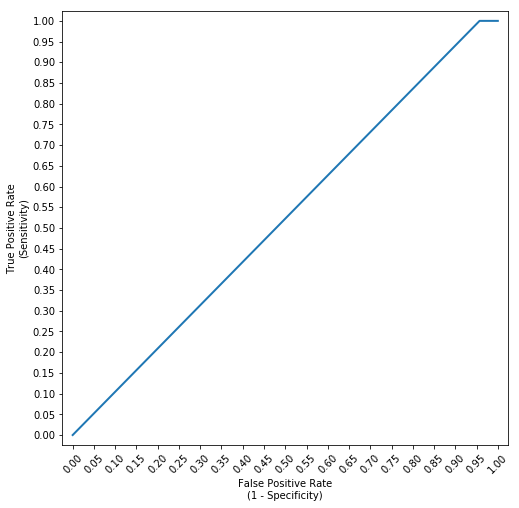

In [481]:
# Plot the roc curve for this model.
predicted_proba = pipeline_b.predict_proba(Xb_test)
plot_roc(yb_test.map(lambda x: x == 2), predicted_proba[:, 1])

The result indicates that the model has greater tendency of predicting a job with salary category 2. Whilst most of the jobs which are in the higher salary category are predicted to be of lower salary category, most of the jobs with salary category 1 will be wrongly predicted with higher salary category.

In addition, tweaking the model will reduce the accuracy of the model as most of the jobs will be predicted at a lower salary category.

## Discussion

### Factors that impact salary
The results indicates that using Naive Bayes is a better model to classify salary. Prediction of salary category is not significantly influenced by number of years of experience. In addition, given the lower accuracy rate for both models used to predict salary category, there is a concern that the models here may not be highly reliable for predicting salary.

Experience is not included as a separate feature in building the model to predicting salary as they are written in the requirements and hence require extraction from the text. In addition, experience is the only quantitive feature in predicting the salary and it's not the only feature that can influence salary. Other factors include the scope of responsibilites, education level, level of responsibilities of the position and the demand and supply of talents in the industry, especially when the hiring market is the free market. More importantly, the salary amount also depends on the company's ability to offer the pay listed on the job description, which can be determined by the size and the finanical strength of the company. Unfortunately, it is impossible to determine the size and financial strength from the job description alone. 

### Factors that distingush job category
The model built using Naive Bayes to classify seniority of the position reflects the differing job scope at different levels of seniority. For instance, jobs under "Senior" class may involve management as the word is relatively more common in the "Senior" class than in other classes, while the word "business" is relative less common in the "Junior" class, indicating that people in Junior job positions may not be as involved in business as compared to those in more Senior positions. The model built using Random Forest reflects a lot of the relationship between job scope and responsibilities and the seniority class. 

However, what is not done here is to use job title as target variable and the job description as feature in building a new model. Although it can be done using topic modelling, there are huge variations in the job titles, especially in between companies - where different companies give different job titles for the same job scope and responsibilty. Also, there is no model to predict job category label as most of the labels are "Information Technology" especially when all of the jobs in this dataset are considered tech-jobs and not every description (responsibilities and requirements) contains information on the description of the line of business. Absence of important features will make the model relative inaccurate and unreliable.  

## Appendix: Web scrapping program listing
This program listing details the python code that is used to scrape job information from the website and save them as a single dataset in one csv file.